In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MaxAbsScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [3]:
url_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
columns = ['frequency',
           'angle_of_attack', 
           'chord_length', 
           'free_stream_velocity',
           'suction_side_displacement_thickness',
           'scaled_sound_pressure_level']

features = ['frequency','angle_of_attack', 
            'chord_length', 
            'free_stream_velocity',
            'suction_side_displacement_thickness']

df = pd.read_csv(url_file, sep='\t', header=None, names=columns)

In [4]:
df.head()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [5]:
df.tail()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224
1502,6300,15.6,0.1016,39.6,0.052849,104.204


In [6]:
df.describe()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   frequency                            1503 non-null   int64  
 1   angle_of_attack                      1503 non-null   float64
 2   chord_length                         1503 non-null   float64
 3   free_stream_velocity                 1503 non-null   float64
 4   suction_side_displacement_thickness  1503 non-null   float64
 5   scaled_sound_pressure_level          1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [8]:
def preprocess_input(df):
    
    train_data = df.copy()
    train_set = train_data.drop("scaled_sound_pressure_level", axis = 1)
    train_labels = train_data["scaled_sound_pressure_level"].copy()
    
    train_set = QuantileTransformer(random_state=0).fit_transform(train_set)
    train_set = MaxAbsScaler().fit_transform(train_set)
    train_set = StandardScaler().fit_transform(train_set)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(train_set, train_labels, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_input(df)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1052, 5)
(451, 5)
(1052,)
(451,)


In [11]:
model = Sequential()

model.add(Input(X_train.shape[1],))

model.add(Dense(48, activation = 'relu'))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(loss = 'mean_squared_error', metrics = tf.keras.metrics.RootMeanSquaredError())

In [13]:
def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes

In [14]:
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape) + index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

In [15]:
shape = get_shape(model)
num_solutions = 20
num_dimensions = 337

In [16]:
def evaluate_nn(W):
    model.set_weights(set_shape(W,shape))
    score = model.evaluate(X_train, y_train, verbose = 0)
    return score[1]

In [17]:
# generate the solutions

current_population_vectors = np.random.uniform(size = (num_solutions, num_dimensions))

print(current_population_vectors.shape)

(20, 337)


In [18]:
epochs, global_best_error, best_solution = 1000, float("inf"), None
iteration_errors = []

In [19]:
import Grey_Wolves as GWO

In [20]:
def sech(x):
    return 1 / np.cosh(x)

In [21]:
def HGWO(agent_vector, agent_error, X_alpha, X_beta, X_delta, a_alpha, a_beta, a_delta):
    
    A1 = a_alpha * (2 * np.random.rand(num_dimensions) - 1)
    A2 = a_beta * (2 * np.random.rand(num_dimensions) - 1)
    A3 = a_delta * (2 * np.random.rand(num_dimensions) - 1)
    C1 = 2 * np.random.rand(num_dimensions)
    C2 = 2 * np.random.rand(num_dimensions)
    C3 = 2 * np.random.rand(num_dimensions)
    X1 = X_alpha - (A1 * np.abs((C1 * X_alpha) - agent_vector))
    X2 = X_beta - (A2 * np.abs((C2 * X_beta) - agent_vector))
    X3 = X_delta - (A3 * np.abs((C3 * X_delta) - agent_vector))

    Y = (X1 + X2 + X3) / 3
    y_error = evaluate_nn(Y)
    if y_error < agent_error:
        agent_vector = Y
        agent_error = y_error

    return agent_vector, agent_error

In [22]:
# calculate error of each solution
curr_errors = np.empty(shape=(num_solutions))
for i in range(num_solutions):
    curr_errors[i] = evaluate_nn(current_population_vectors[i])

In [23]:
for epoch in range(epochs):
    
    print("Epoch ", epoch + 1)
        
    # get the alpha, beta and delta of the population
    X_alpha, X_beta, X_delta = GWO.find_alpha_beta_delta(current_population_vectors, curr_errors)
    x_alpha_score = evaluate_nn(X_alpha)
    x_beta_score = evaluate_nn(X_beta)
    x_delta_score = evaluate_nn(X_delta)
    print("Top three least errors : ", x_alpha_score, x_beta_score, x_delta_score)
    
    # Generate a_alpha, a_beta, a_delta
    
    x = epoch/epochs
    a_alpha = np.power(sech(4 * x), 2)
    a_delta = np.power(sech(3 * x), 2)
    a_beta = (a_alpha + a_delta) * 0.5
#   RMSE - 4.06, 4.11  R2 Score - 0.6484, 0.6507   MAE - 3.06, 3.028, MSE - 16.56, 16.93

#     a_alpha = np.sqrt(sech(4 * x))
#     a_delta = np.sqrt(sech(3 * x))
#     a_beta = (a_alpha + a_delta) * 0.5
#   RMSE - 3.85, 4.09  R2 Score - 0.688, 0.639  MAE - 2.91, 3.14  MSE - 14.88, 16.8
#   RMSE - 4.61, 4.61  R2 Score - 0.559, 0.534  MAE - 3.46, 3.42  MSE - 21.26, 21.28 

#     a_alpha = sech(4 * x)
#     a_delta = sech(3 * x)
#     a_beta = (a_alpha + a_delta) * 0.5
#   RMSE - 4.37, 4.55 R2 Score - 0.597, 0.567 MAE - 3.415, 3.465 MSE - 19.109, 20.688
    
    # update each wolf
    for i in range(num_solutions):
        
        current_population_vectors[i], curr_errors[i] = HGWO(current_population_vectors[i], curr_errors[i], X_alpha, X_beta, X_delta, 
                                                              a_alpha, a_beta, a_delta) 
        
        if (curr_errors[i] < global_best_error):
            best_solution = current_population_vectors[i]
            global_best_error = curr_errors[i]
    
    # print the best error
    print('Best error : ', global_best_error, '\n')
    iteration_errors.append(global_best_error)

Epoch  1
Top three least errors :  105.82736206054688 105.98745727539062 106.43038177490234
Best error :  105.22640991210938 

Epoch  2
Top three least errors :  105.22640991210938 105.6222915649414 105.82736206054688
Best error :  103.65567779541016 

Epoch  3
Top three least errors :  103.65567779541016 104.545654296875 104.72819519042969
Best error :  102.93706512451172 

Epoch  4
Top three least errors :  102.93706512451172 103.44577026367188 103.65567779541016
Best error :  102.17757415771484 

Epoch  5
Top three least errors :  102.17757415771484 102.73641967773438 102.8827896118164
Best error :  98.90713500976562 

Epoch  6
Top three least errors :  98.90713500976562 99.9518814086914 100.08502960205078
Best error :  98.3700180053711 

Epoch  7
Top three least errors :  98.3700180053711 98.40526580810547 98.61431121826172
Best error :  96.16395568847656 

Epoch  8
Top three least errors :  96.16395568847656 96.1963119506836 97.08873748779297
Best error :  91.95137786865234 

Epoc

Top three least errors :  12.692182540893555 13.121211051940918 13.229482650756836
Best error :  12.692182540893555 

Epoch  67
Top three least errors :  12.692182540893555 13.121211051940918 13.229482650756836
Best error :  12.692182540893555 

Epoch  68
Top three least errors :  12.692182540893555 13.065692901611328 13.121211051940918
Best error :  12.424053192138672 

Epoch  69
Top three least errors :  12.424053192138672 12.692182540893555 12.84867000579834
Best error :  12.341135025024414 

Epoch  70
Top three least errors :  12.341135025024414 12.424053192138672 12.692182540893555
Best error :  12.341135025024414 

Epoch  71
Top three least errors :  12.341135025024414 12.424053192138672 12.692182540893555
Best error :  12.257994651794434 

Epoch  72
Top three least errors :  12.257994651794434 12.341135025024414 12.424053192138672
Best error :  12.022634506225586 

Epoch  73
Top three least errors :  12.022634506225586 12.169554710388184 12.257994651794434
Best error :  12.02263

Best error :  7.632840633392334 

Epoch  132
Top three least errors :  7.632840633392334 7.781003952026367 7.781771183013916
Best error :  7.569605827331543 

Epoch  133
Top three least errors :  7.569605827331543 7.632840633392334 7.781003952026367
Best error :  7.569605827331543 

Epoch  134
Top three least errors :  7.569605827331543 7.632840633392334 7.781003952026367
Best error :  7.569605827331543 

Epoch  135
Top three least errors :  7.569605827331543 7.632840633392334 7.781003952026367
Best error :  7.569605827331543 

Epoch  136
Top three least errors :  7.569605827331543 7.632840633392334 7.781003952026367
Best error :  7.569605827331543 

Epoch  137
Top three least errors :  7.569605827331543 7.632840633392334 7.781003952026367
Best error :  7.549891471862793 

Epoch  138
Top three least errors :  7.549891471862793 7.569605827331543 7.632840633392334
Best error :  7.549891471862793 

Epoch  139
Top three least errors :  7.549891471862793 7.569605827331543 7.632840633392334


Best error :  5.026919364929199 

Epoch  198
Top three least errors :  5.026919364929199 5.139430522918701 5.154172420501709
Best error :  5.026919364929199 

Epoch  199
Top three least errors :  5.026919364929199 5.051774501800537 5.058889865875244
Best error :  5.026919364929199 

Epoch  200
Top three least errors :  5.026919364929199 5.051774501800537 5.058889865875244
Best error :  5.026919364929199 

Epoch  201
Top three least errors :  5.026919364929199 5.051774501800537 5.058889865875244
Best error :  4.99222469329834 

Epoch  202
Top three least errors :  4.99222469329834 5.026919364929199 5.051774501800537
Best error :  4.99222469329834 

Epoch  203
Top three least errors :  4.99222469329834 5.026919364929199 5.051774501800537
Best error :  4.8906965255737305 

Epoch  204
Top three least errors :  4.8906965255737305 4.99222469329834 5.026919364929199
Best error :  4.8906965255737305 

Epoch  205
Top three least errors :  4.8906965255737305 4.897893905639648 4.99222469329834
Be

Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  264
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  265
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  266
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  267
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  268
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  269
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  270
Top three least errors :  4.475930690765381 4.495624542236328 4.499395847320557
Best error :  4.475930690765381 

Epoch  271


Best error :  4.321054935455322 

Epoch  329
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  330
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  331
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  332
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  333
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  334
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  335
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254
Best error :  4.321054935455322 

Epoch  336
Top three least errors :  4.321054935455322 4.332911491394043 4.338120460510254


Best error :  4.306571006774902 

Epoch  394
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.306571006774902 

Epoch  395
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.306571006774902 

Epoch  396
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.306571006774902 

Epoch  397
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.306571006774902 

Epoch  398
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.306571006774902 

Epoch  399
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.306571006774902 

Epoch  400
Top three least errors :  4.306571006774902 4.307356834411621 4.3087358474731445
Best error :  4.292726516723633 

Epoch  401
Top three least errors :  4.292726516723633 4.306571006774902 4.307356834

Best error :  4.235451698303223 

Epoch  460
Top three least errors :  4.235451698303223 4.240122318267822 4.250894546508789
Best error :  4.235451698303223 

Epoch  461
Top three least errors :  4.235451698303223 4.240122318267822 4.250894546508789
Best error :  4.235451698303223 

Epoch  462
Top three least errors :  4.235451698303223 4.240122318267822 4.2407331466674805
Best error :  4.235451698303223 

Epoch  463
Top three least errors :  4.235451698303223 4.240122318267822 4.2407331466674805
Best error :  4.235451698303223 

Epoch  464
Top three least errors :  4.235451698303223 4.240122318267822 4.2407331466674805
Best error :  4.235451698303223 

Epoch  465
Top three least errors :  4.235451698303223 4.240122318267822 4.2407331466674805
Best error :  4.233682155609131 

Epoch  466
Top three least errors :  4.233682155609131 4.235451698303223 4.240122318267822
Best error :  4.233682155609131 

Epoch  467
Top three least errors :  4.233682155609131 4.235451698303223 4.240122318267

Best error :  4.219103813171387 

Epoch  526
Top three least errors :  4.219103813171387 4.219536304473877 4.2210845947265625
Best error :  4.219103813171387 

Epoch  527
Top three least errors :  4.219103813171387 4.219536304473877 4.2210845947265625
Best error :  4.219103813171387 

Epoch  528
Top three least errors :  4.219103813171387 4.219536304473877 4.2210845947265625
Best error :  4.219103813171387 

Epoch  529
Top three least errors :  4.219103813171387 4.219536304473877 4.2210845947265625
Best error :  4.219103813171387 

Epoch  530
Top three least errors :  4.219103813171387 4.219536304473877 4.2210845947265625
Best error :  4.219103813171387 

Epoch  531
Top three least errors :  4.219103813171387 4.219536304473877 4.2210845947265625
Best error :  4.212094306945801 

Epoch  532
Top three least errors :  4.212094306945801 4.219103813171387 4.219536304473877
Best error :  4.2016921043396 

Epoch  533
Top three least errors :  4.2016921043396 4.211727142333984 4.21209430694580

Best error :  4.184261798858643 

Epoch  592
Top three least errors :  4.184261798858643 4.184266090393066 4.184445858001709
Best error :  4.184261798858643 

Epoch  593
Top three least errors :  4.184261798858643 4.184266090393066 4.184445858001709
Best error :  4.178203105926514 

Epoch  594
Top three least errors :  4.178203105926514 4.184261798858643 4.184266090393066
Best error :  4.178203105926514 

Epoch  595
Top three least errors :  4.178203105926514 4.184261798858643 4.184266090393066
Best error :  4.178203105926514 

Epoch  596
Top three least errors :  4.178203105926514 4.184261798858643 4.184266090393066
Best error :  4.178203105926514 

Epoch  597
Top three least errors :  4.178203105926514 4.184261798858643 4.184266090393066
Best error :  4.178203105926514 

Epoch  598
Top three least errors :  4.178203105926514 4.184261798858643 4.184266090393066
Best error :  4.178203105926514 

Epoch  599
Top three least errors :  4.178203105926514 4.184261798858643 4.184266090393066


Best error :  4.146148204803467 

Epoch  658
Top three least errors :  4.146148204803467 4.148326873779297 4.1485090255737305
Best error :  4.146148204803467 

Epoch  659
Top three least errors :  4.146148204803467 4.148326873779297 4.1485090255737305
Best error :  4.146148204803467 

Epoch  660
Top three least errors :  4.146148204803467 4.148326873779297 4.1485090255737305
Best error :  4.146148204803467 

Epoch  661
Top three least errors :  4.146148204803467 4.148326873779297 4.1485090255737305
Best error :  4.146148204803467 

Epoch  662
Top three least errors :  4.146148204803467 4.146585464477539 4.148326873779297
Best error :  4.145445823669434 

Epoch  663
Top three least errors :  4.145445823669434 4.146148204803467 4.146213054656982
Best error :  4.145445823669434 

Epoch  664
Top three least errors :  4.145445823669434 4.146148204803467 4.146213054656982
Best error :  4.143426895141602 

Epoch  665
Top three least errors :  4.143426895141602 4.145445823669434 4.146148204803

Best error :  4.128093719482422 

Epoch  724
Top three least errors :  4.128093719482422 4.128337383270264 4.128477573394775
Best error :  4.128093719482422 

Epoch  725
Top three least errors :  4.128093719482422 4.128337383270264 4.1284613609313965
Best error :  4.12726354598999 

Epoch  726
Top three least errors :  4.12726354598999 4.128093719482422 4.128337383270264
Best error :  4.12726354598999 

Epoch  727
Top three least errors :  4.12726354598999 4.128093719482422 4.128337383270264
Best error :  4.12726354598999 

Epoch  728
Top three least errors :  4.12726354598999 4.128093719482422 4.1282057762146
Best error :  4.12726354598999 

Epoch  729
Top three least errors :  4.12726354598999 4.127453804016113 4.128093719482422
Best error :  4.12726354598999 

Epoch  730
Top three least errors :  4.12726354598999 4.127429962158203 4.127453804016113
Best error :  4.126500129699707 

Epoch  731
Top three least errors :  4.126500129699707 4.12726354598999 4.127429962158203
Best error :

Best error :  4.1113200187683105 

Epoch  790
Top three least errors :  4.1113200187683105 4.112401485443115 4.1124348640441895
Best error :  4.1113200187683105 

Epoch  791
Top three least errors :  4.1113200187683105 4.112401485443115 4.1124348640441895
Best error :  4.1113200187683105 

Epoch  792
Top three least errors :  4.1113200187683105 4.112283229827881 4.112401485443115
Best error :  4.1113200187683105 

Epoch  793
Top three least errors :  4.1113200187683105 4.11196231842041 4.1120781898498535
Best error :  4.111103057861328 

Epoch  794
Top three least errors :  4.111103057861328 4.111942291259766 4.11196231842041
Best error :  4.110852241516113 

Epoch  795
Top three least errors :  4.110852241516113 4.111103057861328 4.111942291259766
Best error :  4.110709190368652 

Epoch  796
Top three least errors :  4.110709190368652 4.110852241516113 4.111942291259766
Best error :  4.110709190368652 

Epoch  797
Top three least errors :  4.110709190368652 4.110852241516113 4.1109571

Top three least errors :  4.094457149505615 4.094601631164551 4.094680309295654
Best error :  4.093459606170654 

Epoch  856
Top three least errors :  4.093459606170654 4.093823432922363 4.0941267013549805
Best error :  4.093217849731445 

Epoch  857
Top three least errors :  4.093217849731445 4.093387126922607 4.093459606170654
Best error :  4.093217849731445 

Epoch  858
Top three least errors :  4.093217849731445 4.093387126922607 4.093459606170654
Best error :  4.093217849731445 

Epoch  859
Top three least errors :  4.093217849731445 4.093387126922607 4.093459606170654
Best error :  4.092817783355713 

Epoch  860
Top three least errors :  4.092817783355713 4.092906951904297 4.093217849731445
Best error :  4.092817783355713 

Epoch  861
Top three least errors :  4.092817783355713 4.092830657958984 4.092852592468262
Best error :  4.0924835205078125 

Epoch  862
Top three least errors :  4.0924835205078125 4.092484474182129 4.092817783355713
Best error :  4.0924835205078125 

Epoch  

Best error :  4.0811448097229 

Epoch  921
Top three least errors :  4.0811448097229 4.081153869628906 4.08115816116333
Best error :  4.080451488494873 

Epoch  922
Top three least errors :  4.080451488494873 4.080471038818359 4.080646514892578
Best error :  4.080348014831543 

Epoch  923
Top three least errors :  4.080348014831543 4.080451488494873 4.080469131469727
Best error :  4.080348014831543 

Epoch  924
Top three least errors :  4.080348014831543 4.080399036407471 4.080451488494873
Best error :  4.080033779144287 

Epoch  925
Top three least errors :  4.080033779144287 4.080247402191162 4.080287933349609
Best error :  4.080033779144287 

Epoch  926
Top three least errors :  4.080033779144287 4.080247402191162 4.080269813537598
Best error :  4.0799336433410645 

Epoch  927
Top three least errors :  4.0799336433410645 4.080033779144287 4.080225467681885
Best error :  4.079753398895264 

Epoch  928
Top three least errors :  4.079753398895264 4.080033779144287 4.080225467681885
Bes

Top three least errors :  4.072573184967041 4.072585582733154 4.072633266448975
Best error :  4.072573184967041 

Epoch  987
Top three least errors :  4.072573184967041 4.072585582733154 4.072633266448975
Best error :  4.071988105773926 

Epoch  988
Top three least errors :  4.071988105773926 4.0722336769104 4.07236909866333
Best error :  4.071451187133789 

Epoch  989
Top three least errors :  4.071451187133789 4.071988105773926 4.072159767150879
Best error :  4.071451187133789 

Epoch  990
Top three least errors :  4.071451187133789 4.0719380378723145 4.071988105773926
Best error :  4.071313858032227 

Epoch  991
Top three least errors :  4.071313858032227 4.071451187133789 4.071682929992676
Best error :  4.071313858032227 

Epoch  992
Top three least errors :  4.071313858032227 4.0713276863098145 4.071500778198242
Best error :  4.071202278137207 

Epoch  993
Top three least errors :  4.071202278137207 4.071313858032227 4.0713276863098145
Best error :  4.070677757263184 

Epoch  994


In [24]:
model.set_weights(set_shape(best_solution, shape))

In [25]:
# RMSE
score = model.evaluate(X_train, y_train)
train_rmse, train_mse = score[1], score[0]

score = model.evaluate(X_test, y_test)
test_rmse, test_mse = score[1], score[0]

print("Train RMSE = ", train_rmse)
print("Test RMSE = ", test_rmse)
print("---------------------------")

#MSE
print("Train MSE = ", train_mse)
print("Test MSE = ", test_mse)
print("---------------------------")

#R2 Score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2_score = r2_score(y_train, y_train_pred)
test_r2_score = r2_score(y_test, y_test_pred)

print("Train R2 = ", train_r2_score)
print("Test R2 = ", test_r2_score)
print("-----------------------------")

# MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Train MAE = ", train_mae)
print("Test MAE = ", test_mae)

15/15 [==============================] - 0s 3ms/step - loss: 16.9366 - root_mean_squared_error: 4.1154
Train RMSE =  4.069847583770752
Test RMSE =  4.115414142608643
---------------------------
Train MSE =  16.56365966796875
Test MSE =  16.93663215637207
---------------------------
15/15 [==============================] - 0s 3ms/step
Train R2 =  0.6484096251678595
Test R2 =  0.650713975596932
-----------------------------
Train MAE =  3.060293730645126
Test MAE =  3.0287028724687324


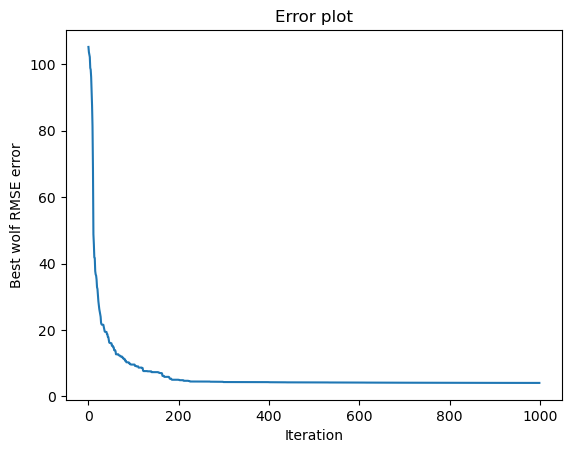

In [26]:
# graph of iteration errors

x_values = range(len(iteration_errors))
plt.plot(x_values, iteration_errors)
plt.xlabel('Iteration')
plt.ylabel('Best wolf RMSE error')
plt.title('Error plot')
plt.show()

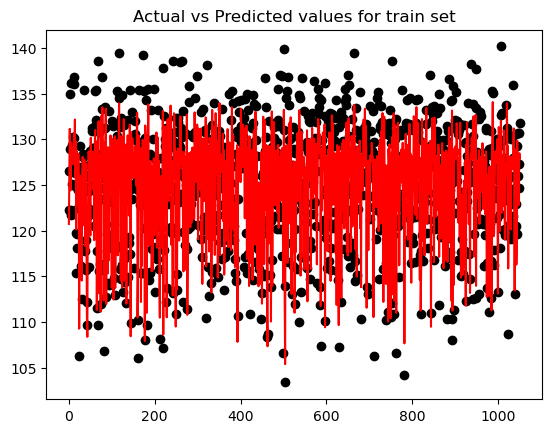

In [27]:
# scatter and line plot for train set

x_values = np.array([i for i in range(X_train.shape[0])])
plt.scatter(x_values, y_train, color = 'black', label = 'Actual values')
plt.plot(x_values, y_train_pred, color = 'red', label = 'Predicted values')
plt.title('Actual vs Predicted values for train set')
plt.show()

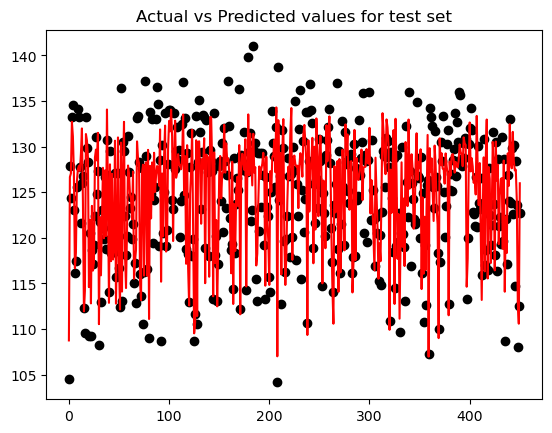

In [28]:
# scatter and line plot for test set

x_values = np.array([i for i in range(X_test.shape[0])])
plt.scatter(x_values, y_test, color = 'black', label = 'Actual values')
plt.plot(x_values, y_test_pred, color = 'red', label = 'Predicted values')
plt.title('Actual vs Predicted values for test set')
plt.show()